In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import json

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 6))
plt.rcParams['figure.figsize'] = [20, 8]


<Figure size 1152x432 with 0 Axes>

In [3]:
train = pd.read_csv('../data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [4]:
test = pd.read_csv('../data/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

#### Thoughts on variables:
- A big **budget** does not necessarily leads to a big revenue, money needs to be spent on the right places.
- a **language** might not influence the revenue, but the **number of spoken languages** might do. (check if the number of spoken languages influences the revenue)
- **popularity** is a floating varible; it does not seem to influence the revenue so I decided to drop it
- **Crew** is definitely an very important factor in predicting the box office. I can import some external data to measure the influence of an individual actor/producer, like the number of followers on Twitter.
- Does **ratings** of the movies influence revenues?


#### Unused columns for modeling:
- id
- imdb_id
- original_title
- (overview0)
- popularity (what is it exactly?)
- poster_path

### Thoughts about external datasets:
- Box offices of movies increasingly rely on their performance in foreign markets; is it possible to integrate the information of foreign market distribution?
- Missing budget/revenue data, it can be recovered(scrapped from imdbpro)
- 

In [5]:
# drop these columns, for now
train = train.drop(columns=['id', 'popularity', 'homepage', 'poster_path', 'status', 'original_title', 'overview', 'tagline'])
test = test.drop(columns=['id', 'popularity', 'homepage', 'poster_path', 'status', 'original_title', 'overview', 'tagline'])

# save imdb_id, title for now

In [6]:
train['budget'] = train['budget'].replace(0, np.nan)
test['budget'] = test['budget'].replace(0, np.nan)
train['revenue'] = train['revenue'].replace(0, np.nan)

## EDA

In [7]:
train.head(100)

,belongs_to_collection,budget,genres,imdb_id,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,title,Keywords,cast,crew,revenue
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000.0,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,NaN,3300000.0,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,NaN,1200000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,NaN,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,NaN,8000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt0093743,en,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,NaN,14000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",tt0431021,en,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Possession,NaN,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,NaN,NaN,"[{'id': 99, 'name': 'Documentary'}]",tt0391024,en,NaN,NaN,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,"[{'id': 256377, 'name': 'The Muppet Collection...",NaN,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0117110,en,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/16/96,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Muppet Treasure Island,"[{'id': 2041, 'name': 'island'}, {'id': 4418, ...","[{'cast_id': 1, 'character': 'Long John Silver...","[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391
9,NaN,6000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",tt0310281,en,"[{'name': 'Castle Rock Entertainment', 'id': 97}]","[{'iso_3166_1': 'US', 'name': 'United States o...",4/16/03,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",A Mighty Wind,"[{'id': 11800, 'name': 'mockumentary'}, {'id':...","[{'cast_id': 24, 'character': 'Jonathan

In [8]:
train.describe()

,budget,runtime,revenue
count,2.188000e+03,2998.000000,3.000000e+03
mean,3.089305e+07,107.856571,6.672585e+07
std,4.026785e+07,22.086434,1.375323e+08
min,1.000000e+00,0.000000,1.000000e+00
25%,5.150000e+06,94.000000,2.379808e+06
50%,1.600000e+07,104.000000,1.680707e+07
75%,4.000000e+07,118.000000,6.891920e+07
max,3.800000e+08,338.000000,1.519558e+09


In [9]:
train.isna().sum()

belongs_to_collection    2396
budget                    812
genres                      7
imdb_id                     0
original_language           0
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [10]:
test.isna().sum()

belongs_to_collection    3521
budget                   1211
genres                     16
imdb_id                     0
original_language           0
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [11]:
# introduce new variable: earn_money, try to figure out what cause a movie to lose revenue
train['earn_money'] = train['budget'] < train['revenue']

### Numerical Variables:

In [12]:
train[['budget', 'runtime', 'revenue']].corr()

,budget,runtime,revenue
budget,1.000000,0.219426,0.739841
runtime,0.219426,1.000000,0.216380
revenue,0.739841,0.216380,1.000000


We can see that the correlation between revenue and budget is most obvious.

#### Budget:

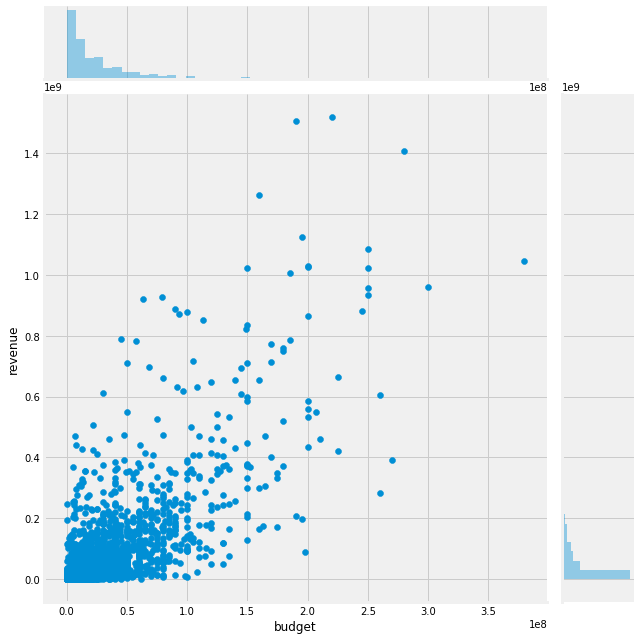

In [13]:
sns.jointplot(x=train['budget'], y=train['revenue'], height=9, ratio=6)

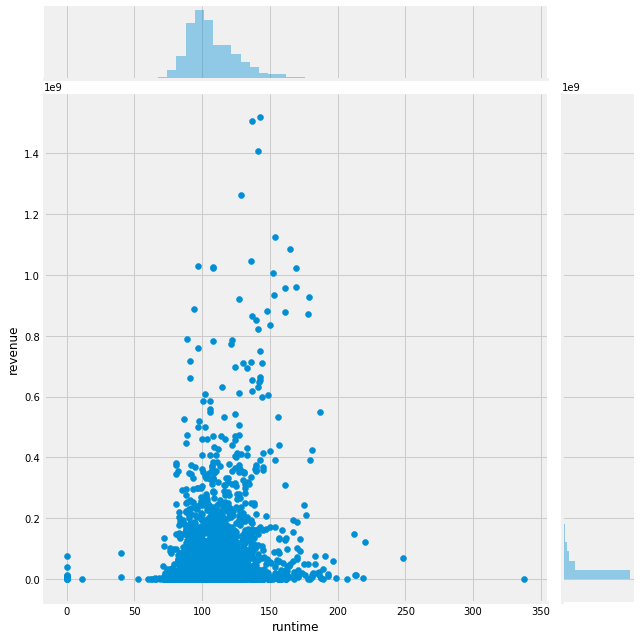

In [14]:
sns.jointplot(x=train['runtime'], y=train['revenue'], height=9, ratio=6)

## Date_released and how do other variables relate to date_released:
I found date_released to be an really interesting variable. It can be a lens by which we can discover the trends and patterns of the movie market. Before digging into the dataset, I have these questions in mind:
- How do revenues fluctuate along these years?
- How do revenues fluctuate between different months of each year? 
- Do lengths of films change?  

In [15]:
#Since only last two digits of year are provided, this is the correct way of getting the year.
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

### A General View: 

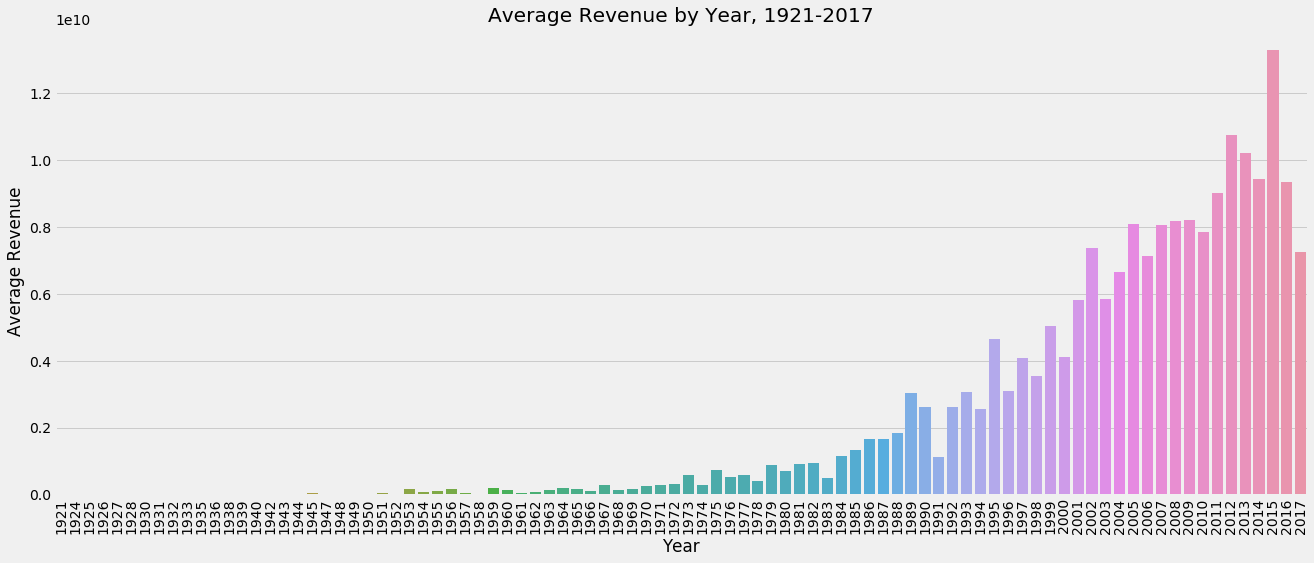

In [18]:
avg_rev_by_year = train.groupby('release_year')['revenue'].sum()
avg_rev_by_year_plot = sns.barplot(x=avg_rev_by_year.index, y=avg_rev_by_year.values)
avg_rev_by_year_plot.set_xticklabels(labels=avg_rev_by_year.index, rotation=90)
avg_rev_by_year_plot.set(xlabel='Year', ylabel='Average Revenue', title='Average Revenue by Year, 1921-2017')
plt.show()

#### We can see that there can be huge difference between average revenues between the years. Interestingly, if you take a look at the history of Hollywood, 

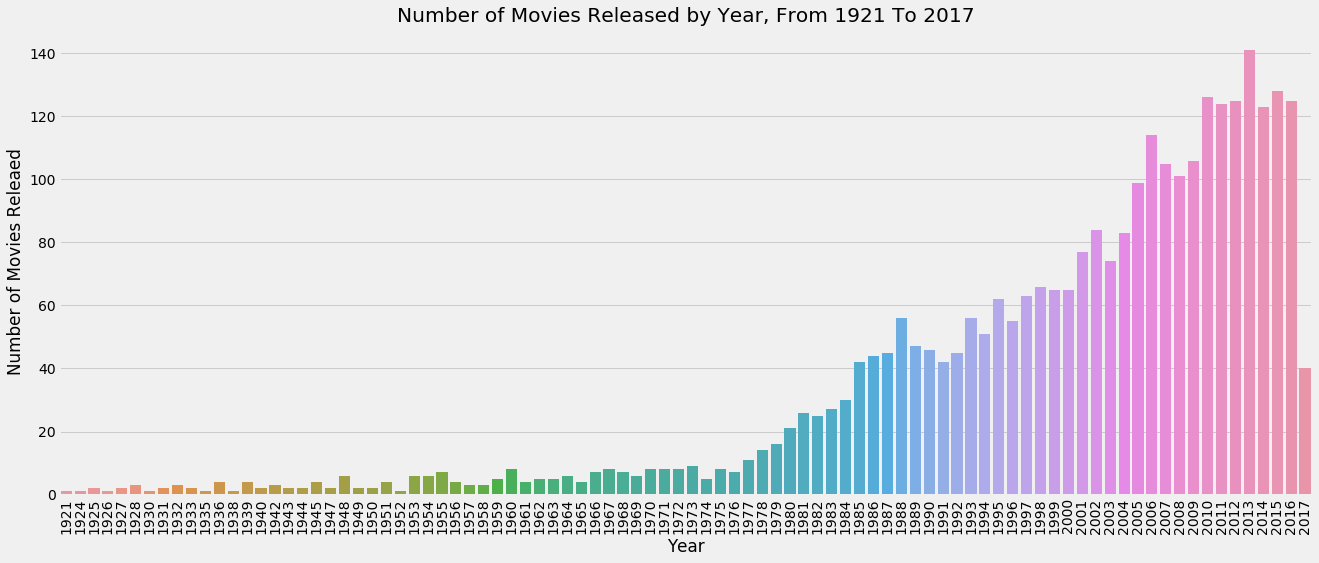

In [19]:
num_by_year = train.groupby('release_year')['imdb_id'].count()
num_by_year_plot = sns.barplot(x=num_by_year.index, y=num_by_year.values)
num_by_year_plot.set_xticklabels(labels=num_by_year.index, rotation=90)
num_by_year_plot.set(xlabel='Year', ylabel='Number of Movies Releaed', title='Number of Movies Released by Year, From 1921 To 2017')
plt.show()

#### Total number of movies released per year increased along the years obviously.

### Runtime:

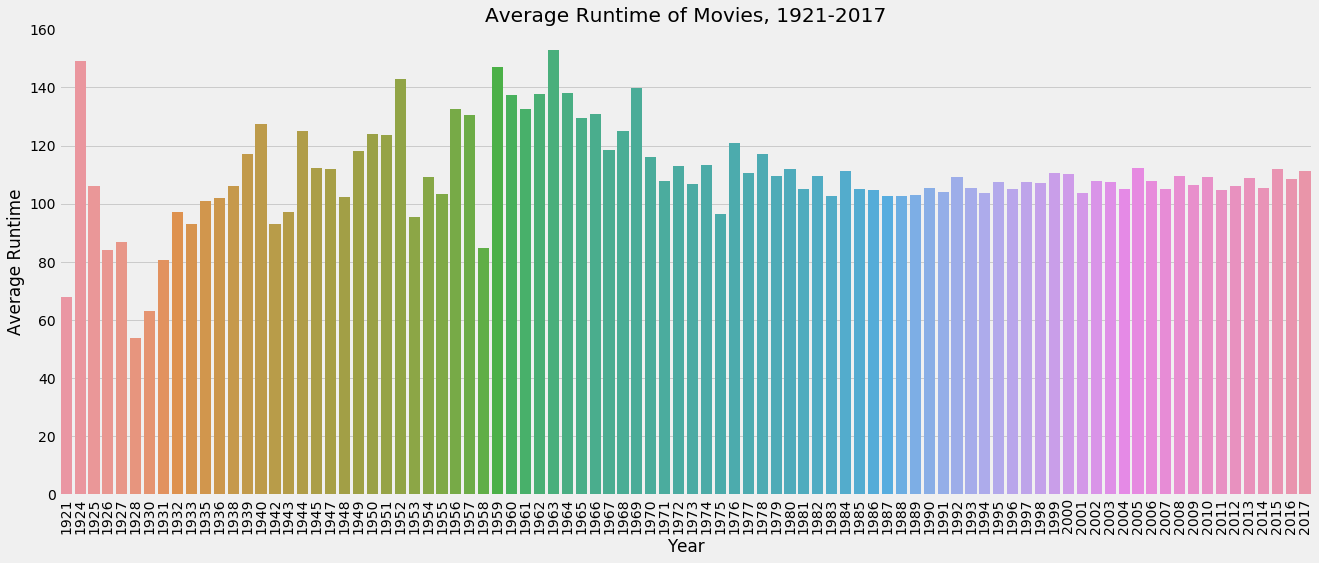

In [20]:
avg_runtime_by_year = train.groupby('release_year')['runtime'].mean()
avg_runtime_by_year_plot = sns.barplot(x=avg_runtime_by_year.index, y =avg_runtime_by_year.values)
avg_runtime_by_year_plot.set_xticklabels(labels=avg_runtime_by_year.index, rotation=90)
avg_runtime_by_year_plot.set(xlabel='Year', ylabel='Average Runtime', title='Average Runtime of Movies, 1921-2017')
plt.show()

#### There no clear trend for the length of movies.

### Revenue by Month / Number of Movies Released by Month:

[Text(0, 0.5, 'Average Revenue'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Revenues by Month, 1921-2017')]

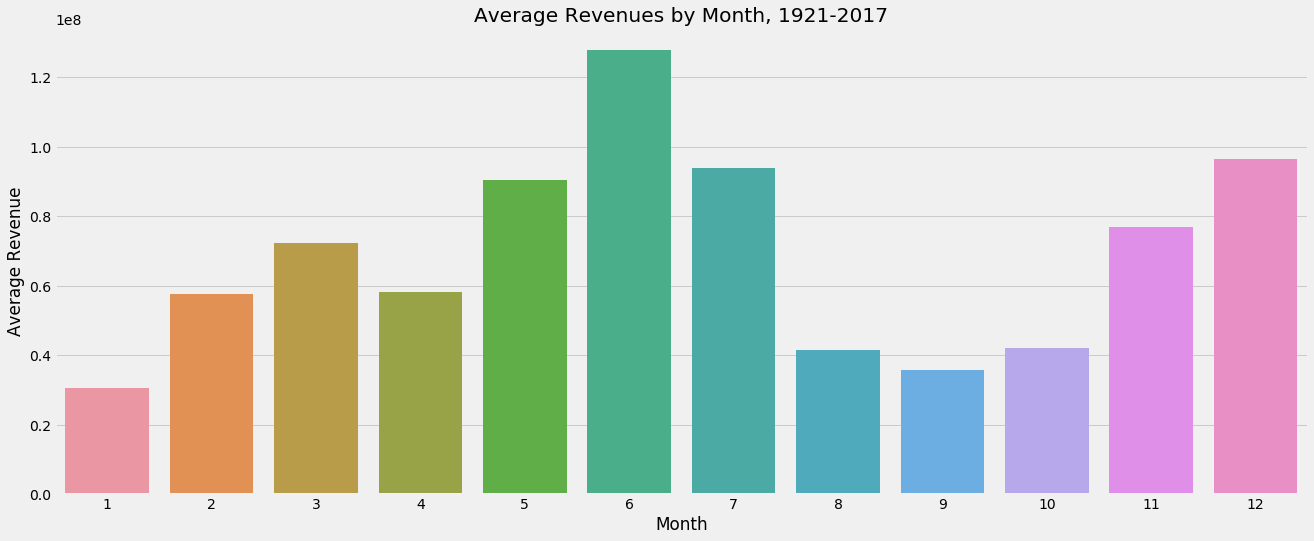

In [21]:
avg_rev_by_month = train.groupby('release_month')['revenue'].mean()
avg_rev_by_month_plot = sns.barplot(x= avg_rev_by_month.index, y=avg_rev_by_month.values)
avg_rev_by_month_plot.set(xlabel='Month', ylabel='Average Revenue', title='Average Revenues by Month, 1921-2017')

#### By observing the average monthly revenues through 1921 to 2017, a trend can be found that average revenues were highest between Maarch to July and November to December.

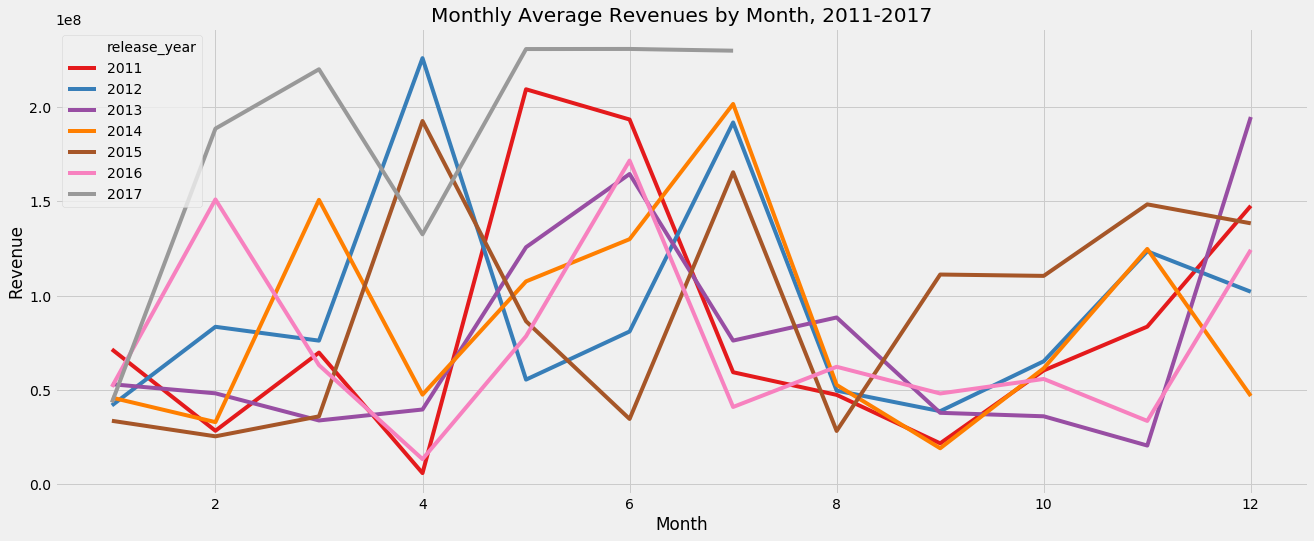

In [22]:
df = train[train['release_year'] > 2010]
avg_rev_by_year_and_month = df.groupby(['release_year', 'release_month'], as_index=False)['revenue'].mean()
avg_rev_by_year_and_month_plot = sns.lineplot(data=avg_rev_by_year_and_month, x='release_month', y='revenue', hue = 'release_year', legend = 'full', palette='Set1')
avg_rev_by_year_and_month_plot.set(xlabel='Month', ylabel='Revenue', title='Monthly Average Revenues by Month, 2011-2017')
avg_rev_by_year_and_month_plot

**The same trend can be found when taking a closer look at monthly average revenues between 2010-2017.**

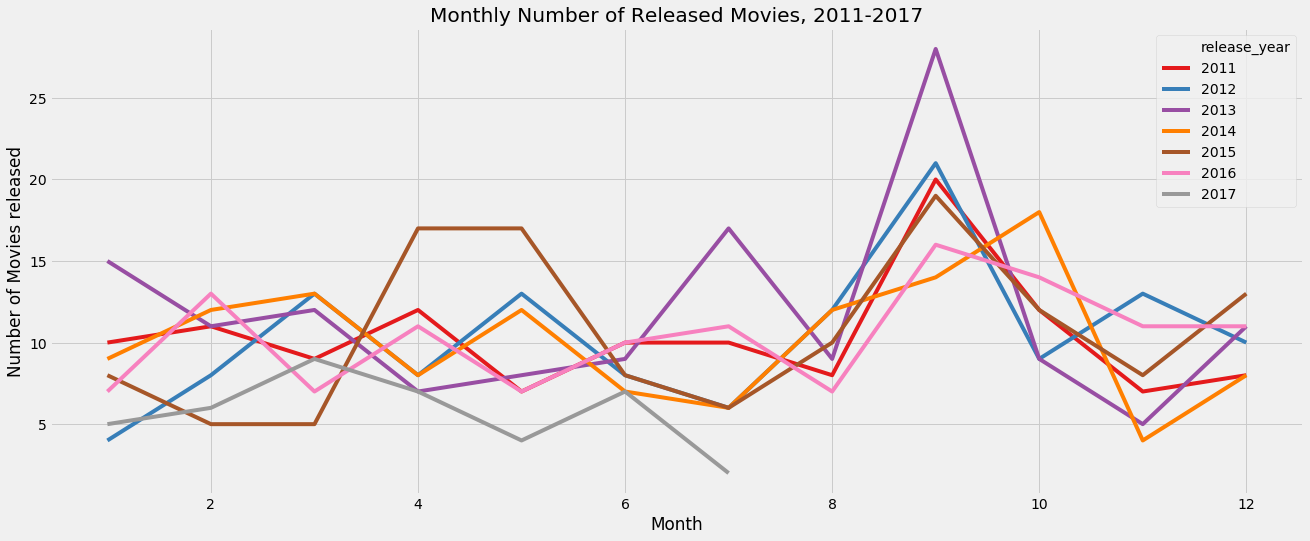

In [23]:
num_of_movies_by_year_and_month = df.groupby(['release_year', 'release_month'], as_index=False)['imdb_id'].count()
num_of_movies_by_year_and_month_plot = sns.lineplot(data=num_of_movies_by_year_and_month, x='release_month', y='imdb_id', hue='release_year', legend='full', palette='Set1')
num_of_movies_by_year_and_month_plot.set(xlabel='Month', ylabel='Number of Movies released', title='Monthly Number of Released Movies, 2011-2017')
plt.show()

**By contrast, August to October see the most number of movies released when we look at the data from 2011-2017. (The same pattern persists for previous years also.)**

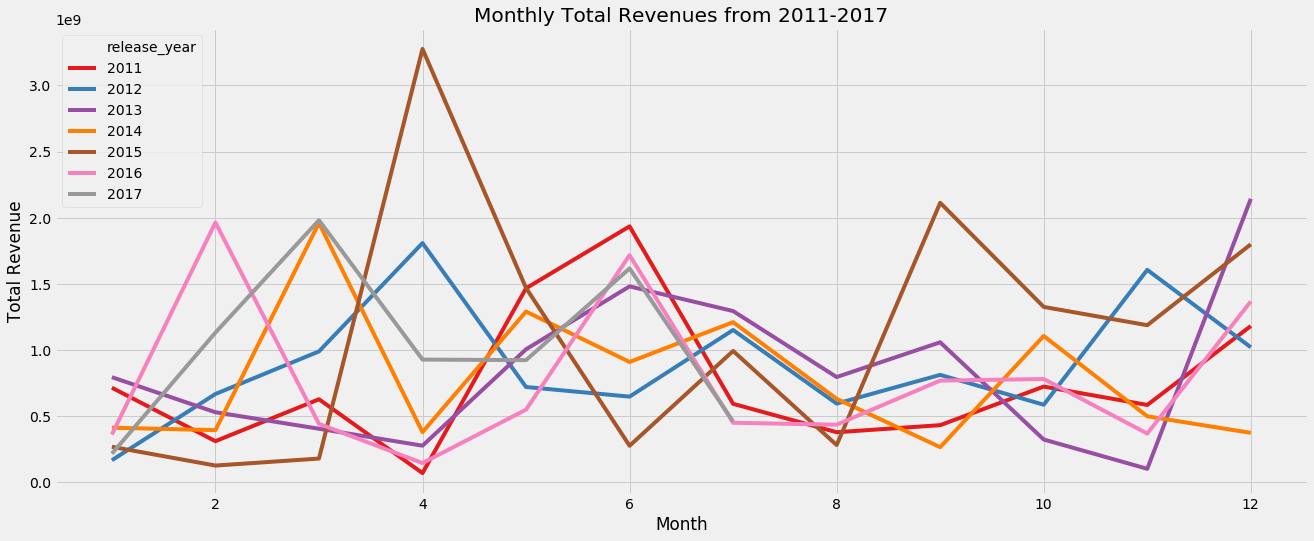

In [24]:
sum_of_rev_by_year_and_month = df.groupby(['release_year', 'release_month'], as_index=False)['revenue'].sum()
sum_of_rev_by_year_and_month_plot = sns.lineplot(data=sum_of_rev_by_year_and_month, x='release_month', y='revenue', hue='release_year', palette='Set1', legend='full')
sum_of_rev_by_year_and_month_plot.set(xlabel='Month', ylabel='Total Revenue', title='Monthly Total Revenues from 2011-2017')
plt.show()

**Same pattern can be identified by looking at monthly total revenues (except for 2015).**

**A closer look at this trend is provided below, where we can compare the average revenues with number of releases each year:**

In [278]:
def display_monthly_avg_rev_by_year(year):
    df = train[train['release_year'] == year]
    table = df.groupby('release_month')['revenue'].mean()
    avg_rev_by_month_plot = sns.barplot(x=table.index, y=table.values)
    avg_rev_by_month_plot.set(xlabel='Month', ylabel='Average Revenue', title='Average Revenues by Month in '+ str(year))
    plt.show()
    
def display_monthly_num_of_movies_by_year(year):
    df = train[train['release_year'] == year]
    table = df.groupby('release_month', as_index=False)['imdb_id'].count()
    plot = sns.barplot(data=table, x='release_month', y='imdb_id')
    plot.set(xlabel='Month', ylabel='Number of Movies released', title='Number of Released Movies by Month in ' + str(year))
    plt.show()

def compare_num_with_rev_by_year(year):
    display_monthly_avg_rev_by_year(year)
    display_monthly_num_of_movies_by_year(year)


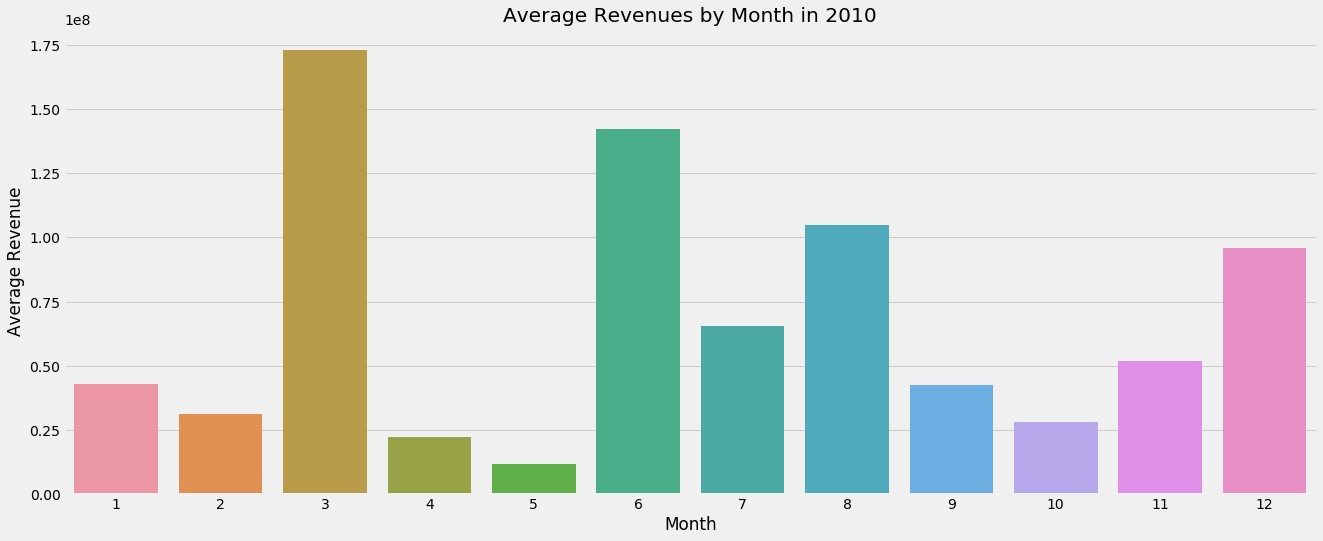

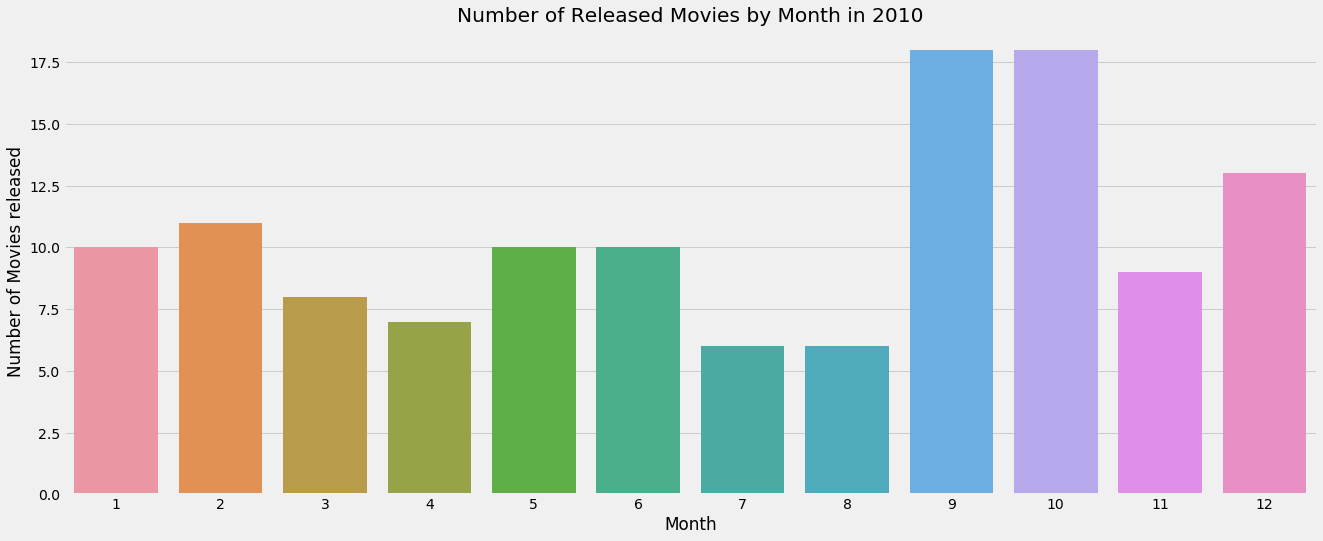

In [279]:
compare_num_with_rev_by_year(2010)

A trend can be identified by comparing monthly number of movies released and monthly average revenues: they seem to be inversely correlated.

#### Genre:

### Summary for release_year and release_month:
1. Revenues are generally low during Jan to March, also August-October. There are called Dump Months, more information can be found at:
    - https://www.wikiwand.com/en/Dump_months
    - https://web.archive.org/web/20151012234912/http://www.theatlantic.com/entertainment/archive/2012/01/january-dumping-ground-for-terrible-movies-like-contraband/251326/
    - https://web.archive.org/web/20150922062108/http://www.avclub.com/article/hollywoods-trash-our-treasure-17-salvageable-flops-91570
    

In [175]:
train['release_year'].value_counts()

2013    141
2015    128
2010    126
2016    125
2012    125
2011    124
2014    123
2006    114
2009    106
2007    105
2008    101
2005     99
2002     84
2004     83
2001     77
2003     74
1998     66
1999     65
2000     65
1997     63
1995     62
1993     56
1988     56
1996     55
1994     51
1989     47
1990     46
1992     45
1987     45
1986     44
       ... 
1959      5
1956      4
1936      4
1951      4
1965      4
1961      4
1945      4
1939      4
1958      3
1957      3
1942      3
1928      3
1932      3
1940      2
1944      2
1950      2
1949      2
1943      2
1933      2
1931      2
1927      2
1925      2
1947      2
1926      1
1930      1
1952      1
1938      1
1935      1
1921      1
1924      1
Name: release_year, Length: 90, dtype: int64

### Categorical Variables:

#### Original Language:

In [89]:
train['production_countries'][0]

"[{'iso_3166_1': 'US', 'name': 'United States of America'}]"